### main_flux_finetune_baselines.py
This notebook reads in HLS S30/L30 data and MERRA-2 processed data and uses
Prithvi-EO-2.0-300M/ Prithvi-EO-2.0-300M-TL (with temporal and location embedding) to
regress GPP flux at eddy covariance observation sites.

Authors: Srija Chakraborty, Besart Mujeci (MERRA variables selection), Yanghui Kang (flux inputs)

Usage:
```
    jupyter lab main_flux_finetune_baselines_trainer.ipynb
```

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
import glob

import pickle
import argparse
from typing import Optional
from functools import partial
import pandas as pd
import rasterio
from flux_load_data_vInf3 import flux_dataset, flux_dataloader
from flux_regress import RegressionModel_flux

from PIL import Image
from flux_load_data_vInf3 import load_raster
from flux_load_data_vInf3 import preprocess_image
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torcheval.metrics import R2Score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from torchgeo.trainers import BaseTask

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
from terratorch.models import EncoderDecoderFactory
from terratorch.datasets import HLSBands
from terratorch.tasks import PixelwiseRegressionTask
from terratorch.models.pixel_wise_model import freeze_module

In [3]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Evaluation metrics to log while training

In [4]:
def get_mse(pred, targ):
    criterion = nn.MSELoss()
    mse_loss = criterion(pred, targ)
    return mse_loss.item()

def get_mae(pred, targ):
    criterion = nn.L1Loss()
    mae_loss = criterion(pred, targ)
    return mae_loss.item()

#can use sklearn R2 instead -- as used to evalute whole dataset
def get_r_sq(pred,targ):
    metric = R2Score()
    metric.update(pred, targ)
    r2=metric.compute()
    # Extracting the first element if it's a tensor with multiple elements
    if isinstance(r2, torch.Tensor) and r2.numel() > 1:
        return r2[0].item()
    else:
        return r2.item()

### Wrapper for the Prithvi model. 

In [5]:
class prithvi_terratorch(nn.Module):

    def __init__(self, prithvi_weight, model_instance, input_size):

        super(prithvi_terratorch, self).__init__()

        # load checkpoint for Prithvi_global

        self.weights_path = prithvi_weight
        self.checkpoint = torch.load(self.weights_path)
        self.input_size = input_size

        self.prithvi_model = model_instance
        
        self.prithvi_model.load_state_dict(self.checkpoint, strict=False)

    def freeze_encoder(self):
        
        freeze_module(self.prithvi_model)

    def forward(self,x,temp,loc,mask):
        
        latent,_,ids_restore = self.prithvi_model.forward(x,temp,loc,mask)

        return latent


### Reading model configs from YAML file. 

In [6]:

with open('fluxconfig_trainer.yaml', 'r') as file:
        config = yaml.safe_load(file)

device=config["device_name"]
n_channel=config["model"]["n_channel"]
embed_dim = config["model"]["embed_dim"]
patch_size = config["model"]["patch_size"]
num_heads = config["model"]["num_heads"]
mlp_ratio = config["model"]["mlp_ratio"]
decoder_depth = config["model"]["decoder_depth"]
head_dropout = config["model"]["head_dropout"]

n_frame=config["data"]["n_frame"]
n_iteration=config["n_iteration"]
checkpoint_dir=config["logging"]["checkpoint_dir"]
metrics_dir=config["logging"]["metrics_dir"]
plots_dir=config["logging"]["plots_dir"]
train_batch_size=config["training"]["train_batch_size"]
test_batch_size=config["testing"]["test_batch_size"]
optim_name=config["training"]["optimizer"]["name"]
learning_rate=float(config["training"]["optimizer"]["params"]["lr"])
sch=config["training"]["scheduler"]["use"]
drp=sch=config["training"]["dropout"]["use"]
drp_rate=float(config["training"]["dropout"]["val"])
bn=sch=float(config["training"]["bn"])
#class_weights=config["class_weights"]
input_size=config["data"]["input_size"]
chips=config["data"]["chips"]
chips_test=config["data"]["test_chips"]
year_to_test=config["test_year"]
print('TEST YEAR', year_to_test)
means=config["data"][f"means_for{year_to_test}test"]
stds=config["data"][f"stds_for{year_to_test}test"]
merra_means=config["data"][f"merra_means_for{year_to_test}test"]
merra_stds=config["data"][f"merra_stds_for{year_to_test}test"]
gpp_means=config["data"][f"gpp_means_for{year_to_test}test"]
gpp_stds=config["data"][f"gpp_stds_for{year_to_test}test"]
test_year=config["test_year"]
norm=config["normalization"]

TEST YEAR 2020


### Reading information about the datasets, as paths to the files and variables used to normalize them. 

In [7]:
#read merra, gpp inputs
df = pd.read_csv("data_train_hls_37sites_v0_1.csv")

#get train_test splits
test_df = df[df['year'] == year_to_test]
test_chips = test_df['Chip'].tolist()
merra_test = test_df[['T2MIN', 'T2MAX', 'T2MEAN', 'TSMDEWMEAN', 'GWETROOT', 'LHLAND', 'SHLAND', 'SWLAND', 'PARDFLAND', 'PRECTOTLAND']].values.tolist()
test_target = test_df['GPP'].tolist()

train_df = df[df['year'] != year_to_test]
train_chips = train_df['Chip'].tolist()
merra_train = train_df[['T2MIN', 'T2MAX', 'T2MEAN', 'TSMDEWMEAN', 'GWETROOT', 'LHLAND', 'SHLAND', 'SWLAND', 'PARDFLAND','PRECTOTLAND']].values.tolist()
train_target = train_df['GPP'].tolist()

means=np.array(means)
stds=np.array(stds)
merra_means=np.array(merra_means)
merra_stds=np.array(merra_stds)
gpp_means=np.array(gpp_means)
gpp_stds=np.array(gpp_stds)

### Instantiating the datamodules used to create the training and testing batches. 

In [8]:
#create ordered paits of hls, merra input and flux output based on splits
flux_dataset_train=flux_dataset([chips + '/' + str(ele) for ele in train_chips],means,stds, merra_train, merra_means, merra_stds,gpp_means, gpp_stds, train_target)
flux_dataset_test=flux_dataset([chips_test + '/' + str(ele) for ele in test_chips],means,stds, merra_test, merra_means, merra_stds,gpp_means, gpp_stds, test_target)

datamodule = flux_dataloader(flux_dataset_train, flux_dataset_test, train_batch_size, test_batch_size, config)
datamodule_ = flux_dataloader(flux_dataset_train, flux_dataset_train, train_batch_size, test_batch_size, config)

### Downloading the checkpoint from HuggingFace

In [9]:
from huggingface_hub import hf_hub_download, snapshot_download

if not os.path.isfile("Prithvi_EO_V2_300M_TL.pt"):
    hf_hub_download(
                  repo_id="ibm-nasa-geospatial/Prithvi-EO-2.0-300M-TL",
                  filename="Prithvi_EO_V2_300M_TL.pt",
                  local_dir=".",
         )

### Creating an instance of our custom model used to estimate the carbon flux problem. 

In [10]:
from terratorch.models.backbones.prithvi_mae import PrithviViT

wt_file  = "Prithvi_EO_V2_300M_TL.pt"


prithvi_instance = PrithviViT(
        patch_size=patch_size,
        num_frames=n_frame,
        in_chans=n_channel,
        embed_dim=embed_dim,
        decoder_depth=decoder_depth,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        head_dropout=head_dropout,
        backbone_input_size=[1,50,50],
        encoder_only=False,
        padding=True,
)
prithvi_model = prithvi_terratorch(wt_file, prithvi_instance, [1, 50, 50])
prithvi_model.freeze_encoder()

# Instantiate the regression model
model_comb = RegressionModel_flux(prithvi_model)

### Loss function and optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_comb.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, verbose=True)

### The task object, used to manage the training and inference processes.

In [12]:
task = PixelwiseRegressionTask(None, None, model=model_comb, loss="mse", optimizer="AdamW")

### Instantiating the trainer object (from Pytorch Lightning).

In [13]:
accelerator = "cuda"
checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
num_epochs = n_iteration
experiment = "carbon_flux"
default_root_dir = os.path.join("tutorial_experiments", experiment)
logger = TensorBoardLogger(save_dir=default_root_dir, name=experiment)

trainer = Trainer(
    # precision="16-mixed",
    accelerator=accelerator,
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    max_epochs=num_epochs,
    default_root_dir=default_root_dir,
    log_every_n_steps=1,
    check_val_every_n_epoch=200

)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


### "Zeroshot" evaluation (no training). 

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

-0.06871962547302246


Text(0.5, 1.0, 'R2: -0.06871945631186782')

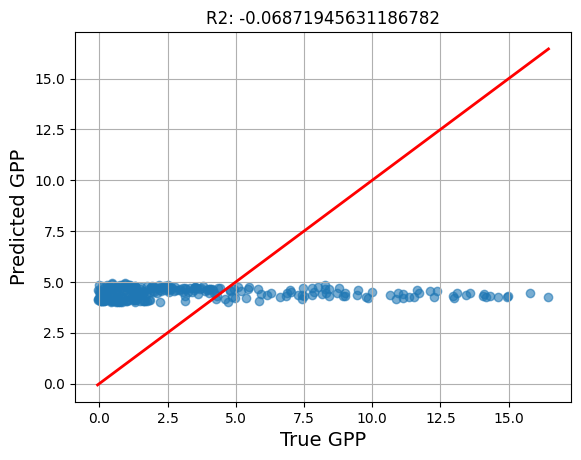

In [14]:
results = trainer.predict(model=task, datamodule=datamodule, return_predictions=True)
pred_test=[i[0] for i in results]
targ_test=[j['mask'] for j in flux_dataset_test]
pred_test = np.concatenate(pred_test, axis=0)
r_norm=r2_score(targ_test, pred_test) #takes true, pred --R2 test set normalized scale (same as unnorm)

print(r_norm)

#gpp_means, std as np.array
mean_gpp = gpp_means.reshape(-1,1,1)  # Mean across height and width, for each channel
stds_gpp = gpp_stds.reshape(-1,1,1)

pred_final_unnorm=pred_test*stds_gpp + mean_gpp
targ_final_unnorm=targ_test*stds_gpp + mean_gpp
pred_final_unnorm=pred_final_unnorm.flatten()[:, None] #np.reshape(pred_final_unnorm,(pred_final_unnorm.shape[1],1))
targ_final_unnorm=targ_final_unnorm.flatten()[:, None] #np.reshape(targ_final_unnorm,(targ_final_unnorm.shape[2],1))
r2_unnorm=r2_score(targ_final_unnorm, pred_final_unnorm)#true,pred
mse_unnorm= (targ_final_unnorm - pred_final_unnorm) ** 2
mae_unnorm= (np.abs(targ_final_unnorm - pred_final_unnorm))
rel_err_unnorm= (np.abs(targ_final_unnorm-pred_final_unnorm)/targ_final_unnorm)#(obs-exp)/obs -- obs: true reading, exp: model pred

test_stack=np.hstack((pred_test, targ_test, pred_final_unnorm, targ_final_unnorm, mse_unnorm, mae_unnorm, rel_err_unnorm))
np.savetxt(f"{metrics_dir}test_eval_MSELoss_ep{num_epochs}_lr{learning_rate}_{optim_name}_sc{sch}_yr{year_to_test}.csv",test_stack,fmt='%10.6f', delimiter=',', newline='\n', header='pred_n, tar_n, pred, tar, mse,mae, rel_err')

#save r2 figure
plt.scatter(targ_final_unnorm, pred_final_unnorm, alpha=0.6)
plt.plot([min(targ_final_unnorm), max(targ_final_unnorm)], [min(targ_final_unnorm), max(targ_final_unnorm)], color='red', lw=2, label='Perfect fit')
plt.xlabel('True GPP', fontsize=14)
plt.ylabel('Predicted GPP', fontsize=14)
plt.grid(True)
plt.title('R2: ' + str(r2_unnorm))

### The training stage. 

In [15]:
trainer.fit(model=task, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ criterion     │ IgnoreIndexLossWrapper │      0 │ train │
│ 1 │ train_metrics │ MetricCollection       │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection       │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection       │      0 │ train │
│ 4 │ model         │ RegressionModel_flux   │  304 M │ train │
└───┴───────────────┴────────────────────────┴────────┴───────┘

Trainable params: 428 K                                                                                            
Non-trainable params: 303 M                                                                                        
Total params: 304 M                                                                                                
Total estimated model params size (MB): 1.2 K                                                                      
Modules in train mode: 545                                                                                         
Modules in eval mode: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### The inference stage. 

In [16]:
results = trainer.predict(model=task, datamodule=datamodule, return_predictions=True)
results_train = trainer.predict(model=task, datamodule=datamodule_, return_predictions=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

### Applying on test set (batches) and deriving metrics, plots. 

In [17]:
# Testing Phase -- test set data in batches
pred_test=[i[0] for i in results]
targ_test=[j['mask'] for j in flux_dataset_test]
pred_train=[i[0] for i in results_train]
targ_train=[j['mask'] for j in flux_dataset_train]

# Concatenate predictions across batches
pred_test = np.concatenate(pred_test, axis=0)
targ_test = np.concatenate(targ_test, axis=0)[:,None]

r_norm=r2_score(targ_test, pred_test) #takes true, pred --R2 test set normalized scale (same as unnorm)

### Unnormalizing data with train mean, std to saving predictions, computing metrics and saving.

Text(0.5, 1.0, 'R2: 0.716891566026854')

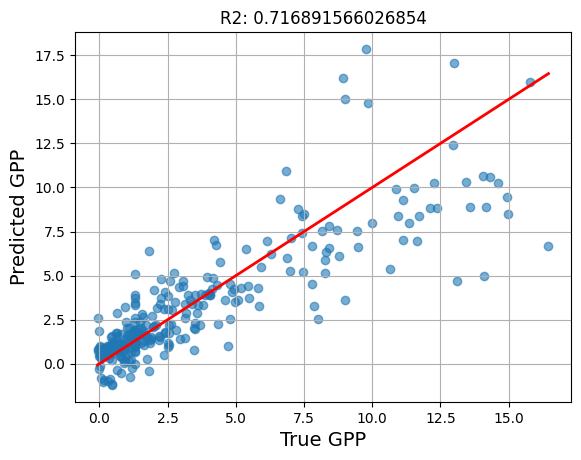

In [18]:
#gpp_means, std as np.array
mean_gpp = gpp_means.reshape(-1,1,1)  # Mean across height and width, for each channel
stds_gpp = gpp_stds.reshape(-1,1,1)

pred_final_unnorm=pred_test*stds_gpp + mean_gpp
targ_final_unnorm=targ_test*stds_gpp + mean_gpp
pred_final_unnorm=pred_final_unnorm.flatten()[:, None] #np.reshape(pred_final_unnorm,(pred_final_unnorm.shape[1],1))
targ_final_unnorm=targ_final_unnorm.flatten()[:, None] #np.reshape(targ_final_unnorm,(targ_final_unnorm.shape[2],1))
r2_unnorm=r2_score(targ_final_unnorm, pred_final_unnorm)#true,pred
mse_unnorm= (targ_final_unnorm - pred_final_unnorm) ** 2
mae_unnorm= (np.abs(targ_final_unnorm - pred_final_unnorm))
rel_err_unnorm= (np.abs(targ_final_unnorm-pred_final_unnorm)/targ_final_unnorm)#(obs-exp)/obs -- obs: true reading, exp: model pred

test_stack=np.hstack((pred_test, targ_test, pred_final_unnorm, targ_final_unnorm, mse_unnorm, mae_unnorm, rel_err_unnorm))
np.savetxt(f"{metrics_dir}test_eval_MSELoss_ep{num_epochs}_lr{learning_rate}_{optim_name}_sc{sch}_yr{year_to_test}.csv",test_stack,fmt='%10.6f', delimiter=',', newline='\n', header='pred_n, tar_n, pred, tar, mse,mae, rel_err')

#save r2 figure
plt.scatter(targ_final_unnorm, pred_final_unnorm, alpha=0.6)
plt.plot([min(targ_final_unnorm), max(targ_final_unnorm)], [min(targ_final_unnorm), max(targ_final_unnorm)], color='red', lw=2, label='Perfect fit')
plt.xlabel('True GPP', fontsize=14)
plt.ylabel('Predicted GPP', fontsize=14)
plt.grid(True)
plt.title('R2: ' + str(r2_unnorm))

### Applying on train set (batches) in eval mode and deriving metrics, plots. 

0.939871179986587


Text(0.5, 1.0, 'R2: 0.939871179986587')

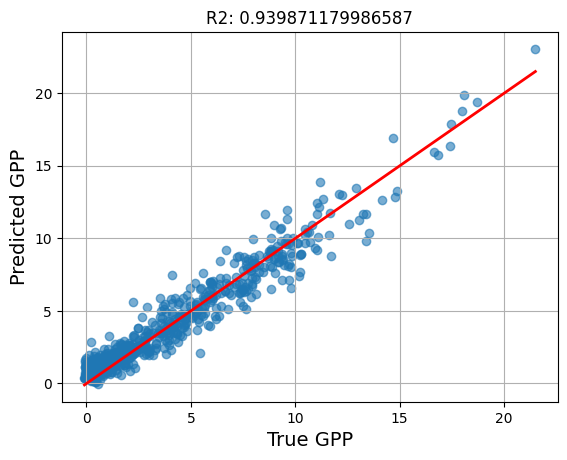

In [19]:
# evaluate performance on training data
pred_test_tr=[i[0] for i in results_train]
targ_test_tr=[j['mask'] for j in flux_dataset_train]

# Concatenate predictions across batches
pred_test_tr = np.concatenate(pred_test_tr, axis=0)
targ_test_tr = np.concatenate(targ_test_tr, axis=0)[:,None]

#unnormalize and save pred, metrics on full training set
pred_final_unnorm_tr=pred_test_tr*stds_gpp + mean_gpp
targ_final_unnorm_tr=targ_test_tr*stds_gpp + mean_gpp

pred_final_unnorm_tr=pred_final_unnorm_tr.flatten()[:, None] #np.reshape(pred_final_unnorm_tr,(pred_final_unnorm_tr.shape[1],1))
targ_final_unnorm_tr=targ_final_unnorm_tr.flatten()[:, None] #np.reshape(targ_final_unnorm_tr,(targ_final_unnorm_tr.shape[2],1))
r2_unnorm_tr=r2_score(targ_final_unnorm_tr, pred_final_unnorm_tr)#true,pred
print(r2_unnorm_tr)
#mse_norm= (test_pred - test_target) ** 2
mse_unnorm_tr= (targ_final_unnorm_tr - pred_final_unnorm_tr) ** 2
mae_unnorm_tr= (np.abs(targ_final_unnorm_tr - pred_final_unnorm_tr))
rel_err_unnorm_tr= (np.abs(targ_final_unnorm_tr-pred_final_unnorm_tr)/targ_final_unnorm_tr)
train_stack=np.hstack((pred_test_tr, targ_test_tr, pred_final_unnorm_tr, targ_final_unnorm_tr ,mse_unnorm_tr, mae_unnorm_tr, rel_err_unnorm_tr))
np.savetxt(f"{metrics_dir}train_eval_MSELoss_ep{num_epochs}_lr{learning_rate}_{optim_name}_sc{sch}_yr{year_to_test}.csv",test_stack,fmt='%10.6f', delimiter=',', newline='\n', header='pred_n, tar_n, pred, tar, mse,mae, rel_err')

#save r2 image
plt.scatter(targ_final_unnorm_tr, pred_final_unnorm_tr, alpha=0.6)
plt.plot([min(targ_final_unnorm_tr), max(targ_final_unnorm_tr)], [min(targ_final_unnorm_tr), max(targ_final_unnorm_tr)], color='red', lw=2, label='Perfect fit')
plt.xlabel('True GPP', fontsize=14)
plt.ylabel('Predicted GPP', fontsize=14)
plt.grid(True)
plt.title('R2: ' + str(r2_unnorm_tr))